# Multi-Armed Bandit Game

In [1]:
from MultiArmedBandit import MultiArmedBandit
from Player import Player
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="dark")
%matplotlib inline

## Stationary bandit
First, we explore a bandit with stationary value functions for each action. The rewards each action gives are sampled from an exponential distribution with a randomly generated, but fixed (hence stationary), scale parameters for each action. The result is that there is an "optimal" action the player must identify through repeated sampling.

In [2]:
bandits = MultiArmedBandit(n=10)
for ii, bandit in enumerate(bandits.get_bandits()):
    print("Bandit {}: Expected value = {:.3f}".format(ii, bandit.get_param("scale")))

Bandit 0: Expected value = 4.260
Bandit 1: Expected value = 0.503
Bandit 2: Expected value = 1.893
Bandit 3: Expected value = 0.184
Bandit 4: Expected value = 3.933
Bandit 5: Expected value = 2.015
Bandit 6: Expected value = 0.007
Bandit 7: Expected value = 3.253
Bandit 8: Expected value = 0.803
Bandit 9: Expected value = 0.601


We define two players, one that always makes the greedy choice and one that allows a bit of exploration. We can tune this degree of exploration. These players independently play the game (the bandits don't change, so all plays will be independent).

In [4]:
def run_stationary_game(bandits, num_games=1000):
    players = [
        Player(bandits=bandits, action_selector="exploratory", exploration_epsilon=0), 
        Player(bandits=bandits, action_selector="exploratory", exploration_epsilon=0.1), 
        Player(bandits=bandits, action_selector="exploratory", exploration_epsilon=0.3)]

    # Play the game N times for each player and keep track of what they earn
    for ii in range(num_games):
        for player in players:
            player.do_action()

    return players

players = run_stationary_game(bandits=bandits)

The players incrementally attempt to identify the mean reward for each of the actions.

In [6]:
for ii, bandit in enumerate(bandits.get_bandits()):
    print(
        "Bandit {}: True Value: {:.3f} | Greedy Player = {:.3f} | " \
        "Exploratory Player = {:.3f} | Very Exploratory Player = {:.3f}".format(
            ii, bandit.get_param("scale"), players[0].get_action_values()[ii], 
            players[1].get_action_values()[ii], players[2].get_action_values()[ii]))

Bandit 0: True Value: 4.260 | Greedy Player = 4.317 | Exploratory Player = 1.993 | Very Exploratory Player = 4.393
Bandit 1: True Value: 0.503 | Greedy Player = 0.000 | Exploratory Player = 0.629 | Very Exploratory Player = 0.657
Bandit 2: True Value: 1.893 | Greedy Player = 0.000 | Exploratory Player = 1.355 | Very Exploratory Player = 2.398
Bandit 3: True Value: 0.184 | Greedy Player = 0.000 | Exploratory Player = 0.238 | Very Exploratory Player = 0.254
Bandit 4: True Value: 3.933 | Greedy Player = 0.000 | Exploratory Player = 4.114 | Very Exploratory Player = 4.270
Bandit 5: True Value: 2.015 | Greedy Player = 0.000 | Exploratory Player = 1.557 | Very Exploratory Player = 2.203
Bandit 6: True Value: 0.007 | Greedy Player = 0.000 | Exploratory Player = 0.003 | Very Exploratory Player = 0.007
Bandit 7: True Value: 3.253 | Greedy Player = 0.000 | Exploratory Player = 3.303 | Very Exploratory Player = 3.578
Bandit 8: True Value: 0.803 | Greedy Player = 0.000 | Exploratory Player = 0.648

We can see that the greedy player sticks with its first guess as the reward will never be negative. The exploratory players learns a reasonable approximation of all the actions.

If we run through the game many times and average over the rewards at each time step we see a trend for all player strategies. We're resetting the bandits every time, so expect some noise on the basis of different reward functions.

In [10]:
all_scores_greedy = []
all_scores_explo1 = []
all_scores_explo2 = []
for ii in range(1000):
    bandits = MultiArmedBandit(n=10)
    players = run_stationary_game(bandits=bandits)
    all_scores_greedy.append(players[0].get_earnings())
    all_scores_explo1.append(players[1].get_earnings())
    all_scores_explo2.append(players[2].get_earnings())
    
average_scores_greedy = np.array(all_scores_greedy).mean(axis=0)
average_scores_explo1 = np.array(all_scores_explo1).mean(axis=0)
average_scores_explo2 = np.array(all_scores_explo2).mean(axis=0)

A look at the performance shows that the exploratory players are much better at playing the game than the greedy one.

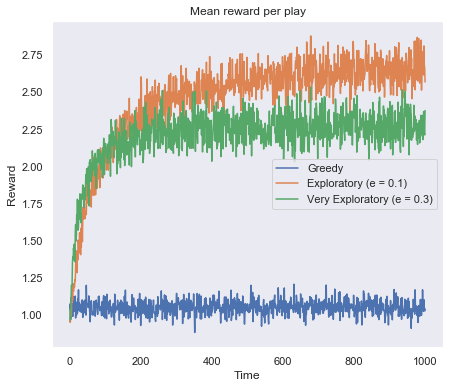

In [11]:
xrange = np.arange(1, 1001)
plt.figure(figsize=(7,6))
plt.plot(xrange, average_scores_greedy, label = 'Greedy')
plt.plot(xrange, average_scores_explo1, label = 'Exploratory (e = 0.1)')
plt.plot(xrange, average_scores_explo2, label = 'Very Exploratory (e = 0.3)')
plt.legend()
plt.title('Mean reward per play')
plt.xlabel('Time')
plt.ylabel('Reward')
plt.show()

## Non-stationary bandit
What happens if the bandit action values become non-stationary, i.e. they slowly change over time? For this, let's assume that with every action, all of the action value distributions undergo a random gaussian walk.